### ML Bootcamp V. Предсказание сердечно-сосудистых заболеваний. Решение на 48 место

##### Изначально было занято 87 место, однако после доработки программы удалось немного передвинуться =)

##### Автор: Мартынов Роман

In [1]:
import math
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from pandas import DataFrame, Series
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import InstanceHardnessThreshold
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### Предобработка 

In [2]:
df_train = pd.read_csv(r'data\train.csv', sep=';')
y_train = df_train['cardio']
df_train.drop(['id', 'cardio'], axis=1, inplace = True)

df_test = pd.read_csv(r'data\test.csv', sep=';', na_values='None')
del df_test['id']

In [3]:
df_train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [4]:
df_test.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18888,1,154,85.0,130,80,1,1,0.0,0.0,1.0
1,19042,2,170,69.0,130,90,1,1,NaN,0.0,1.0
2,20432,1,160,70.0,120,75,1,1,0.0,0.0,0.0
3,18133,2,185,94.0,130,90,1,1,NaN,0.0,1.0
4,16093,2,170,76.0,120,80,1,1,0.0,0.0,1.0


##### -----Исправление роста/веса-----

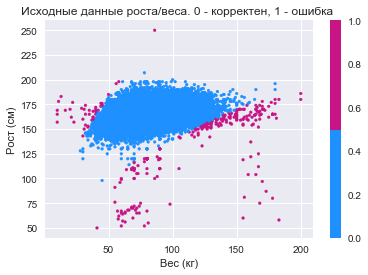

In [5]:
all_data_input = pd.concat([df_train, df_test])
all_data_input['imt'] = all_data_input.weight / (np.square(all_data_input.height) / 10000)

plt.scatter(all_data_input.weight, all_data_input.height, 
            c=((all_data_input.imt < 15) | (all_data_input.imt > 52)), s = 8, 
            cmap=ListedColormap(['dodgerblue','mediumvioletred']))
plt.colorbar()
plt.title('Исходные данные роста/веса. 0 - корректен, 1 - ошибка ')
plt.xlabel('Вес (кг)')
plt.ylabel('Рост (см)')

del all_data_input

In [6]:
    def deviate_weight_height(Data, min_imt = 17, max_imt=50, coef_height = 24, coef_weight = 24, coef_age = 720):
        """Обработка некорректных данных в Data в столбцах 'weight', 'height'
        --------
        Некорректными считались данные пациентов, у которых Индекс Массы Тела -
        ИМТ < min_imt (дистрофия)или ИМТ > max_imt (сверх ожирение)
        --------
        Параметры
        --------
        * max_imt - максимальный индекс ИМТ, говорящий об ожирении
        * min_imt - минимальный индекс ИМТ, говорящий о дистрофии
        * coef_height - ИМТ для рассчета веса по росту
        * coef_weight - ИМТ для рассчета роста по весу
        * coef_age - допустимый отступ от реального возраста влево/вправо для взятия среднего по росту и весу
        """

        tmp_Data = Data.copy()
        # переводим рост в метры
        tmp_Data['height'] /= 100
        tmp_Data['imt'] = tmp_Data['weight'] / (tmp_Data['height'] * tmp_Data['height'])
        # выбор строк с некорректными данными
        dev_Data = tmp_Data[(tmp_Data['imt'] > max_imt) | (tmp_Data['imt'] < min_imt)]
        # выбор строк с корректными данными
        not_dev_Data = tmp_Data[(tmp_Data['imt'] < max_imt) | (tmp_Data['imt'] > min_imt)]

        new_weight = []
        new_height = []
        
        for imt, weight, height, age in zip(dev_Data['imt'],dev_Data['weight'], dev_Data['height'], dev_Data['age']):
            # если рост - нормальный, рассчитываем вес по росту
            if height > 1.20 and height < 2.30:
                weight = coef_height * height * height
            # если вес - нормальный, рассчитываем рост по весу
            elif weight > 30 and weight < 120:
                height = math.sqrt(weight / coef_weight)
            # иначе берем средний рост и вес по пациентам, возраст которых + - 2 года от возраста нашего пациента
            else:
                filter_Data = not_dev_Data[(not_dev_Data['age'] < age + coef_age) &
                                            (not_dev_Data['age'] > age - coef_age)]
                height = filter_Data['height'].mean()
                weight = filter_Data['weight'].mean()
                
            new_height.append(height)
            new_weight.append(weight)

        # изменяем некорректные значения на скорректированные
        mask = (tmp_Data['imt'] > max_imt) | (tmp_Data['imt'] < min_imt)
        
        tmp_Data['height'][mask] = Series(new_height, index=dev_Data.index)
        tmp_Data['weight'][mask] = Series(new_weight, index=dev_Data.index)
        # переводим рост в сантиметры
        tmp_Data['height'] *= 100
        # удаляем вставленный столбец с ИМТ
        tmp_Data = tmp_Data.drop('imt', axis=1)
        return tmp_Data

In [7]:
df_train = deviate_weight_height(df_train, max_imt=52, min_imt=15)
df_test = deviate_weight_height(df_test, max_imt=52, min_imt=15)

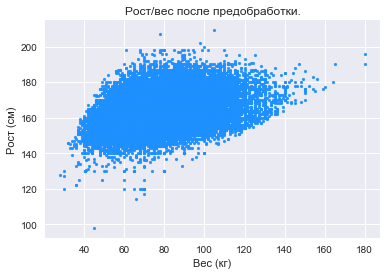

In [8]:
all_data_normal_weight_height = pd.concat([df_train, df_test])
plt.scatter(all_data_normal_weight_height.weight, all_data_normal_weight_height.height, s = 8, c = 'dodgerblue')
plt.title('Рост/вес после предобработки.')
plt.xlabel('Вес (кг)')
plt.ylabel('Рост (см)')
del all_data_normal_weight_height

##### -----Исправление давления-----

In [9]:
def deviate_arterial_pressure(Data):
    """Обработка некорректных данных в Data в столбцах 'ap_hi', 'ap_lo'
    --------
    Некорректными данными считались данные, в которых верхнее давление ниже нижнего,
    верхнее давление < 30 или >300, нижнее < 30 или выше 200
    --------
    Предполагаем, что верхнее давление может быть [малое (<30), нормальное (>30 && <300), большое (>300)]
    Предполагаем, что нижнее давление может быть [малое (<10), нормальное (>10 && <300), большое (>200)]
    """
    # перевод отрицательных значений в положительные целые
    df_abs = Data
    df_abs[['ap_hi', 'ap_lo']] = Data[['ap_hi', 'ap_lo']].abs().astype(int)

    # выбор тех строк таблицы, которые содержат неверные данные о давлении
    mask = (df_abs['ap_hi'] > 300) | (df_abs['ap_hi'] < 30) | (df_abs['ap_lo'] > 200) | (df_abs['ap_lo'] < 10)
    dev_data = df_abs[['ap_hi', 'ap_lo']][mask]

    # средние нормальные давления
    ap_hi_mean = df_abs['ap_hi'].mean()
    ap_lo_mean = df_abs['ap_lo'].mean()

    new_ap_hi = []
    new_ap_lo = []
        
    for ap_hi, ap_lo in zip(dev_data['ap_hi'], dev_data['ap_lo']):
        err_flag = True
        
        # оба давления в норме
        if ap_hi < 300 and ap_hi > 30 and ap_lo < 200 and ap_lo > 10 and ap_hi > ap_lo:
            err_flag = False
            new_ap_hi.append(ap_hi)
            new_ap_lo.append(ap_lo)
                
        # верхнее норма, нижнее большое (160/1100 -> 160/110)
        elif ap_hi < 300 and ap_hi > 30 and ap_lo > 200:
            tmp_ap_hi = ap_hi
            tmp_ap_lo = ap_lo
            f = True
            while(len(str(ap_lo))>1):
                ap_lo /= 10
                ap_lo = math.trunc(ap_lo)
                if ap_lo < 300 and ap_hi > ap_lo:
                    f = False
                    err_flag = False
                    new_ap_lo.append(ap_lo)
                    new_ap_hi.append(ap_hi)
                    break
            if f:
                ap_hi, ap_lo = tmp_ap_hi, tmp_ap_lo
                    
        # верхнее большое, нижнее норма (1600/90 -> 160/90)
        elif ap_hi > 300 and ap_lo < 200 and ap_lo > 10:
            tmp_ap_hi = ap_hi
            tmp_ap_lo = ap_lo
            f = True
            while(len(str(ap_hi) )> 1):
                ap_hi /= 10
                ap_hi = math.trunc(ap_hi)
                if ap_hi < 300 and ap_hi > ap_lo:
                    f = False
                    err_flag = False
                    new_ap_lo.append(ap_lo)
                    new_ap_hi.append(ap_hi)
                    break
            if f:
                ap_hi, ap_lo = tmp_ap_hi, tmp_ap_lo
                    
        # верхнее большое, нижнее малое (906/0 -> 90/60)
        elif ap_hi > 300 and ap_lo < 10:
            mod = ap_hi % 10
            ap_hi /= 10
            ap_hi = math.trunc(ap_hi)
            ap_lo = int(str(mod) + str(ap_lo))
            if ap_hi < 300 and ap_lo > 10 and ap_hi > ap_lo:
                err_flag = False
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                    
        # верхнее малое, нижнее большое (9/770 -> 97/70)
        elif ap_hi < 30 and ap_lo > 200:
            len_ap_lo = len(str(ap_lo))
            first_digit = ap_lo / int('1' + '0' * (len_ap_lo - 1))
            first_digit = math.trunc(first_digit)
            ap_lo = ap_lo % int('1' + '0' * (len_ap_lo - 1))
            ap_hi = int(str(ap_hi) + str(first_digit))
            if ap_hi < 300 and ap_lo > 10 and ap_hi > ap_lo:
                err_flag = False
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                    
        # верхнее норма, нижнее малое (120/8 -> 120/80)
        elif ap_hi < 300 and ap_hi > 10 and ap_lo < 10 and ap_lo != 0:
            ap_lo *= 10
            if ap_lo > 10 and ap_hi > ap_lo:
                err_flag = False
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                    
        # верхнее малое, нижнее норма (8/60 -> 80/60)
        elif ap_hi < 30 and ap_lo < 200 and ap_lo > 10 and ap_hi != 0:
            ap_hi *= 10
            if ap_hi > 10 and ap_hi > ap_lo:
                err_flag = False
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
            
        # ошибка в давлении не исправлена
        if err_flag:
                
            # если оба давления нормальны, но они переставлены местами -> переставляем их (90/180 -> 180/90)
            if ap_hi < 300 and ap_hi > 30 and ap_lo < 200 and ap_lo > 10 and ap_hi < ap_lo:
                ap_hi, ap_lo = ap_lo, ap_hi
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                
            # если верхнее давление нормально, а нижнее с отклонением, заменяем нижнее на среднее
            elif ap_hi < 300 and ap_hi > 30:
                ap_lo = df_abs['ap_lo'][df_abs['ap_hi'] == ap_hi].mean()
                if ap_hi < ap_lo:
                    ap_hi, ap_lo = ap_lo, ap_hi
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                if math.isnan(new_ap_lo[-1]) or math.isnan(new_ap_hi[-1]):
                    new_ap_lo[-1] = ap_lo_mean
                    new_ap_hi[-1] = ap_hi_mean
                        
            # если нижнее давление нормально, а а верхнее с отклонением, заменяем верхнее на среднее
            elif ap_lo < 200 and ap_lo > 10:
                ap_hi = df_abs['ap_hi'][df_abs['ap_lo'] == ap_lo].mean()
                if ap_hi < ap_lo:
                    ap_hi, ap_lo = ap_lo, ap_hi
                new_ap_lo.append(ap_lo)
                new_ap_hi.append(ap_hi)
                if math.isnan(new_ap_lo[-1]) or math.isnan(new_ap_hi[-1]):
                    new_ap_lo[-1] = ap_lo_mean
                    new_ap_hi[-1] = ap_hi_mean
                        
            # заменяем оба значения давления на средние по всей выборке
            else:
                new_ap_lo.append(ap_lo_mean)
                new_ap_hi.append(ap_hi_mean)
                    
    ap_lo_Series = Series(new_ap_lo, index=dev_data['ap_lo'].index)
    ap_hi_Series = Series(new_ap_hi, index=dev_data['ap_hi'].index)

    # Замена неверных значений исправленными
    mask = (df_abs['ap_hi'] > 300) | (df_abs['ap_hi'] < 30) | (df_abs['ap_lo'] > 200) | (df_abs['ap_lo'] < 10)
    df_abs['ap_hi'][mask] = ap_hi_Series
    mask = (df_abs['ap_hi'] > 300) | (df_abs['ap_hi'] < 30) | (df_abs['ap_lo'] > 200) | (df_abs['ap_lo'] < 10)
    df_abs['ap_lo'][mask] = ap_lo_Series

    return df_abs

In [10]:
df_train = deviate_arterial_pressure(df_train)
df_test = deviate_arterial_pressure(df_test)

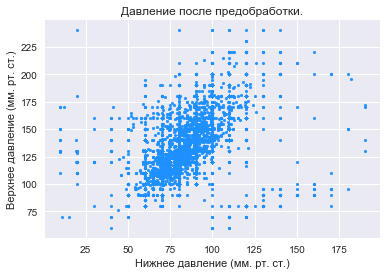

In [11]:
all_data_normal_pressure = pd.concat([df_train, df_test])

plt.scatter(all_data_normal_pressure.ap_lo, all_data_normal_pressure.ap_hi, s = 8, c = 'dodgerblue')
plt.title('Давление после предобработки.')
plt.xlabel('Нижнее давление (мм. рт. ст.)')
plt.ylabel('Верхнее давление (мм. рт. ст.)')

del all_data_normal_pressure

##### -----Прогнозирование употребления алкоголя, занятий спортом, курения-----

In [12]:
    def alco_prognoze(Data_train, Data_test):
        """Прогнозирование употребления алкоголя для NaN значений в столбце 'alco' тестовых данных.
        
        Наилучшие результаты получены с помощью применения одного из методов андерсэмплинга к тренировочной выборке."""
        
        tmp_df_train, tmp_df_test = Data_train, Data_test
        tmp_df_train = tmp_df_train.drop(['active', 'smoke'], axis=1)
        tmp_df_test = tmp_df_test.drop(['active', 'smoke'], axis=1)

        # формирование тренировочной (вся тренировочная + не NaN тестовой) и тестовой (только NaN) выборок
        
        X_train_alco = pd.concat([tmp_df_train, tmp_df_test[~np.isnan(tmp_df_test['alco'])]])
        X_train_alco = X_train_alco.drop(['alco'], axis=1)
        y_train_alco = pd.concat([tmp_df_train['alco'], tmp_df_test['alco'][~np.isnan(tmp_df_test['alco'])]])

        X_test_alco = tmp_df_test[np.isnan(tmp_df_test['alco'])].drop(['alco'], axis = 1)

        # Macro-f-measure: 0.5463
        clf = BaggingClassifier(n_estimators=33)
        pipe_clf = Pipeline([('std', StandardScaler()), ('clf', clf)])

        # работа с несбалансированной выборкой
        smp = InstanceHardnessThreshold
        X_train, y_train = smp().fit_sample(X_train_alco.values, y_train_alco.values)

        print('**********Alco prognose**********')
        print('Balance method: {}, train shape: {}'.format(smp.__name__, Counter(y_train)))
        
        # обучение классификатора и предскаание
        pipe_clf.fit(X_train, y_train)
        y_predict = pipe_clf.predict(np.array(X_test_alco))
        print('Число предсказанных 1/0: {}'.format(Counter(y_predict)))

        # замена NaN на полученные новые значения
        Data_test['alco'][np.isnan(Data_test['alco'])] = Series(y_predict, index=X_test_alco.index)
        return Data_test

In [13]:
 def smoke_prognoze(Data_train, Data_test):
        """Прогнозирование курения для NaN значений в столбце 'smoke' тестовых данных"""
        
        tmp_df_train, tmp_df_test = Data_train, Data_test
        tmp_df_train = tmp_df_train.drop(['active'], axis=1)
        tmp_df_test = tmp_df_test.drop(['active'], axis=1)

        # формирование тренировочной (вся тренировочная + не NaN тестовой) и тестовой (только NaN) выборок
        X_train_smoke = pd.concat([tmp_df_train, tmp_df_test[~np.isnan(tmp_df_test['smoke'])]])
        X_train_smoke = X_train_smoke.drop(['smoke'], axis=1)
        y_train_smoke = pd.concat([tmp_df_train['smoke'], tmp_df_test['smoke'][~np.isnan(tmp_df_test['smoke'])]])

        X_test_smoke = tmp_df_test[np.isnan(tmp_df_test['smoke'])].drop(['smoke'], axis = 1)

        # Macro-f-measure: 0.6673 (если есть алкоголь)
        clf = LogisticRegression()
        pipe_clf = Pipeline([('std', StandardScaler()), ('clf', clf)])
        X_train, y_train = X_train_smoke, y_train_smoke
        print('**********Smoke prognose**********')
        print('Balance method: {}, train shape: {}'.format('-', Counter(y_train)))

        # обучение классификатора и предскаание
        pipe_clf.fit(X_train, y_train)
        y_predict = pipe_clf.predict(np.array(X_test_smoke))
        print('Число предсказанных 1/0: {}'.format(Counter(y_predict)))

        # замена NaN на полученные новые значения
        Data_test['smoke'][np.isnan(Data_test['smoke'])] = Series(y_predict, index=X_test_smoke.index)

        return Data_test

In [14]:
    def active_prognoze(Data_train, Data_test):
        """Прогнозирование курения для NaN значений в столбце 'smoke' тестовых данных"""
        
        tmp_df_train, tmp_df_test = Data_train, Data_test

        # формирование тренировочной (вся тренировочная + не NaN тестовой) и тестовой (только NaN) выборок
        X_train_active = pd.concat([tmp_df_train, tmp_df_test[~np.isnan(tmp_df_test['active'])]])
        X_train_active = X_train_active.drop(['active'], axis=1)
        y_train_active = pd.concat([tmp_df_train['active'], tmp_df_test['active'][~np.isnan(tmp_df_test['active'])]])

        X_test_active = tmp_df_test[np.isnan(tmp_df_test['active'])].drop(['active'], axis = 1)

        # Macro F-measure: 0.5104
        clf = BaggingClassifier(n_estimators=6)
        pipe_clf = Pipeline([('std', StandardScaler()), ('clf', clf)])
        X_train, y_train = X_train_active, y_train_active
        print('**********Active prognose**********')
        print('Balance method: {}, train shape: {}'.format('-', Counter(y_train)))

        # обучение классификатора и предскаание
        pipe_clf.fit(X_train, y_train)
        y_predict = pipe_clf.predict(np.array(X_test_active))
        print('Число предсказанных 1/0: {}'.format(Counter(y_predict)))

        # замена NaN на полученные новые значения
        Data_test['active'][np.isnan(Data_test['active'])] = Series(y_predict, index=X_test_active.index)
        return Data_test

In [15]:
df_test = alco_prognoze(df_train, df_test)
df_test = smoke_prognoze(df_train, df_test)
df_test = active_prognoze(df_train, df_test)

**********Alco prognose**********
Balance method: InstanceHardnessThreshold, train shape: Counter({0.0: 62776, 1.0: 5233})
Число предсказанных 1/0: Counter({0.0: 2841, 1.0: 190})
**********Smoke prognose**********
Balance method: -, train shape: Counter({0.0: 88432, 1.0: 8538})
Число предсказанных 1/0: Counter({0.0: 2898, 1.0: 132})
**********Active prognose**********
Balance method: -, train shape: Counter({1.0: 78104, 0.0: 18999})
Число предсказанных 1/0: Counter({1.0: 2403, 0.0: 494})


###### -----Генерация признаков и построение моделей-----

##### Признаки подбирались вручную с помощью метода последовательного добавления признаков: классификатор стартует  с пустого множества, куда последовательно добавляются признаки (для выбора оптимального на каждом шаге).

In [16]:
data = pd.concat([df_train, df_test], ignore_index=True)
train_index, test_index = np.arange(df_train.shape[0]), np.arange(df_train.shape[0], df_train.shape[0] + df_test.shape[0])

In [17]:
# добавляем индес массы тела
data['bmi'] = data['weight'] / (data['height'] * data['height'] / 10000)

# переводим возраст в годы
data['age'] /= 360.25

##### Разбиваем возраст на интервалы, границы которых получены с помощью нахождения пиков 13 компонент гауссовой смеси. Затем интервалы были поделены пополам, чтобы каждому возрасту соответствовал один интервал.

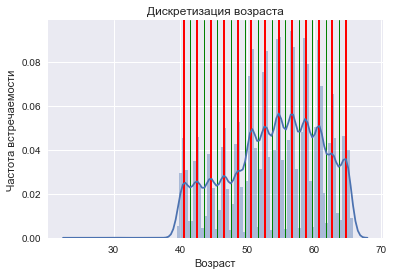

In [18]:
bgm = BayesianGaussianMixture(n_components=13, random_state=5)
bgm.fit(list(map(lambda x: [x], data.loc[train_index].age.values)))
intervals = sorted(bgm.means_[:,0])

for x in intervals:
    plt.axvline(x, linewidth=2, c='r')
    
intervals_popolam = np.array([[left, (left + right) / 2] for left, right in zip(intervals[:-1], intervals[1:])]).flatten()

for x in intervals_popolam[1::2]:
    plt.axvline(x, linewidth=1, c='g')

sns.distplot(data.age, bins=100)

plt.title('Дискретизация возраста')
plt.xlabel('Возраст')
plt.ylabel('Встречаемость')

In [19]:
data['age'] = pd.cut(data.age, bins = [0] + list(intervals_popolam) + [71.7, 100], labels = False)

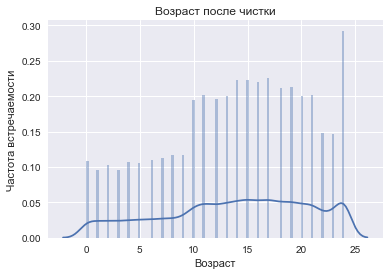

In [20]:
sns.distplot(data.age, bins=100)

plt.title('Возраст после дискретизации')
plt.xlabel('Возраст')
plt.ylabel('Встречаемость')

In [21]:
data['log_ap_gi_*_log_gluc'] = np.log(data.iloc[:,4]) * data.iloc[:,7]

data['log_height_*_log_ap_hi'] = np.log(data.iloc[:,2]) * data.iloc[:,4]

data['log_ap_hi_*_log_ap_lo'] = np.log(data.iloc[:,4]) * np.log(data.iloc[:,5])

data.drop(['weight'], axis=1, inplace=True)

##### Параметры классификаторов подбирались с помощью поиска по сетке GridSearchCV

In [22]:
# 0.538604
clf1 = XGBClassifier(n_estimators=198, max_depth=4, learning_rate=0.048, reg_lambda=14.954, subsample=0.7,
                    objective='reg:logistic',min_child_weight=3, max_delta_step=1, gamma=0.01,
                    base_score=0.49)

# 0.538454
clf2 = LGBMClassifier(n_estimators=61, max_depth=6, learning_rate=0.09, reg_lambda=9.994, subsample=0.7,
                    min_data_in_leaf=0, bagging_freq=1, lambda_l1=0.0011, max_bin=217, min_data_in_bin=3,
                    max_position=10, num_leaves=31)
#0.53836
vot = VotingClassifier([('clf1', clf1), ('clf2', clf2)], voting='soft')
old_cl = Pipeline([('std', StandardScaler()), ('clf', vot)])


In [23]:
print('Финальный результат : {}'.format(
    np.mean(cross_val_score(old_cl, data.loc[train_index], y_train, scoring='neg_log_loss', cv=2))))

Финальный результат : -0.5380418304339964


In [24]:
# запись ответов в файл
old_cl.fit(data.loc[train_index].values, y_train.values)
result = old_cl.predict_proba(data.loc[test_index].values)[:,1]
pd.Series(result).to_csv('predict_proba.csv', index=False)

##### Результат 0.538041 на cv соответсвует результату 0.531228 в привате, то есть является результатом на 48 место среди 656 участников